# 1 . Import des librairies et chartgement des données
-----------------------------------------

In [ ]:
# Datagrame and figures libraries
import pandas as pd
import numpy as np
from IPython.display import HTML

# Graph libraries and modules
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

# Stats and ML libraries and modules
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.stats.stattools import durbin_watson
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC


# Clustering module and libaries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


PATH = '~/project10/dataset/'

dataset = pd.read_csv(PATH + 'billets.csv', sep = ';')

# 2 Analyse du jeu de données
------------------------

## 2.1 Analyse préliminaire du jeu de données
-----------------------------

On définit la variable features qui correspond aux variables de notre dataset.

In [ ]:
features = dataset.columns
display(features)

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

Quelles sont les dimensions de notre dataset ?

In [ ]:
dataset.shape

(1500, 7)

Notre dataset fait 1500 lignes sur 7 colonnes.

Quelle(s) colonne(s) contien(nen)t des valeurs manquantes ?

In [ ]:
missing_value_column = dataset.columns[dataset.isna().any()]
print(missing_value_column)

Index(['margin_low'], dtype='object')


La colonne manquante est la colonne margin_low.

Combien y-a-t-il de valeurs manquantes dans cette colonne ?

In [ ]:
dataset[missing_value_column].isna().sum()

margin_low    37
dtype: int64

37 valeurs sont manquantes dans la colonne margin_low soit 1463 valeurs pleines.

On définit un dataframe comportant les lignes n'ayant pas de données vides (filled-dataset) et un comportant les lignes ayant des données vides  (missing_values_df)

In [ ]:
filled_dataset = dataset.dropna()
missing_values_df = dataset[dataset.isna().any(axis=1)]

# 2.2 Analyse statistique du jeu de donnée
------------------------------

### a) Corrélation des variables sur filled_dataset
-----------------------------------

On définit la fonction de corrélation et de heatmap :

In [ ]:
def correlation_matrix(matrix):
    fig, ax = plt.subplots(figsize=(20, 6))
    # Exclusion des valeurs en double et des valeurs en diagonales (retour faux) dans le but de ne pas les afficher dans notre heatmap option mask de la fonction heatmap sns
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    #Création de la heatmap de corrélation des variables
    sns.heatmap(matrix,mask=mask,xticklabels=matrix.columns.values,
                    yticklabels=matrix.columns.values,cmap=sns.diverging_palette(220, 20, n=200),annot=True,linewidths=.5)
    plt.title('Matrice de corrélation des variables')
    plt.show()


On exclut la variable is_genuine de filled_dataset.

In [ ]:
filled_dataset_without_is_genuine = filled_dataset.drop(columns= ['is_genuine'])

On sépare les vrais des faux de filled_dataset. On exclut, la colonne is_genuine 

In [ ]:
filled_dataset_without_is_genuine_true = filled_dataset[filled_dataset.is_genuine == True]
filled_dataset_without_is_genuine_false = filled_dataset[filled_dataset.is_genuine == False]

filled_dataset_without_is_genuine_true = filled_dataset_without_is_genuine_true.drop(columns= ['is_genuine'])
filled_dataset_without_is_genuine_false = filled_dataset_without_is_genuine_false.drop(columns= ['is_genuine'])

#### Corrélation des variables sans distinction de vrais ou de faux
--------------------------------

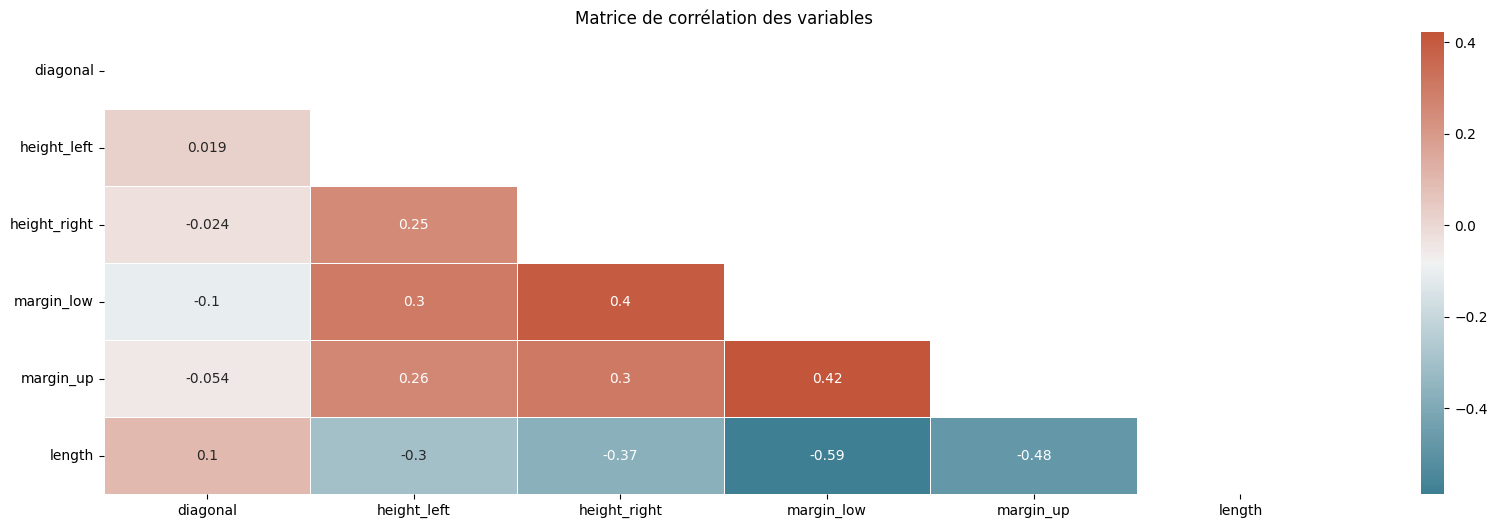

In [ ]:
matrix = filled_dataset_without_is_genuine.corr(method = 'spearman')

correlation_matrix(matrix)

Avant séparation des données, on constate une relative corrélation entre les variables suivantes : 
<li> margin_low : height_right, lenght, margin_low  </li>
<li> margin_up : lenght</li>

#### Corrélation des variables si is_genuine est vrai
--------------------------------

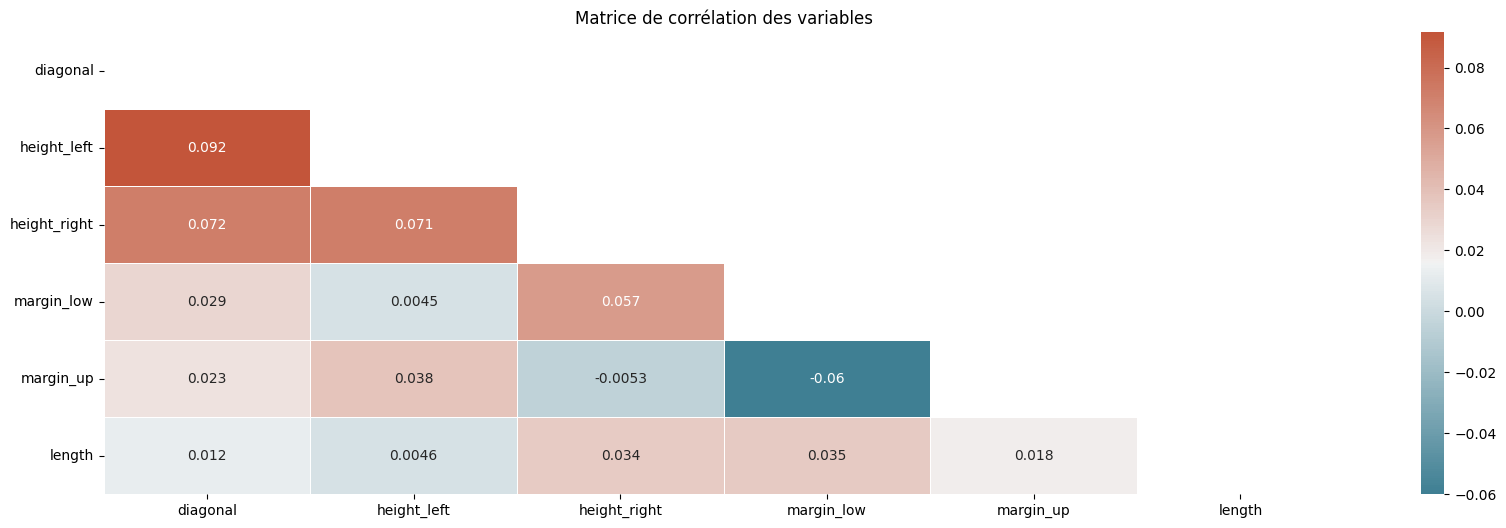

In [ ]:
matrix = filled_dataset_without_is_genuine_true.corr(method = 'spearman')

correlation_matrix(matrix)

Il n'y a pas de corrélation significative des variables quand is_genuine est vrai

#### Corrélation des variables si is_genuine est faux
------------------------------------------------

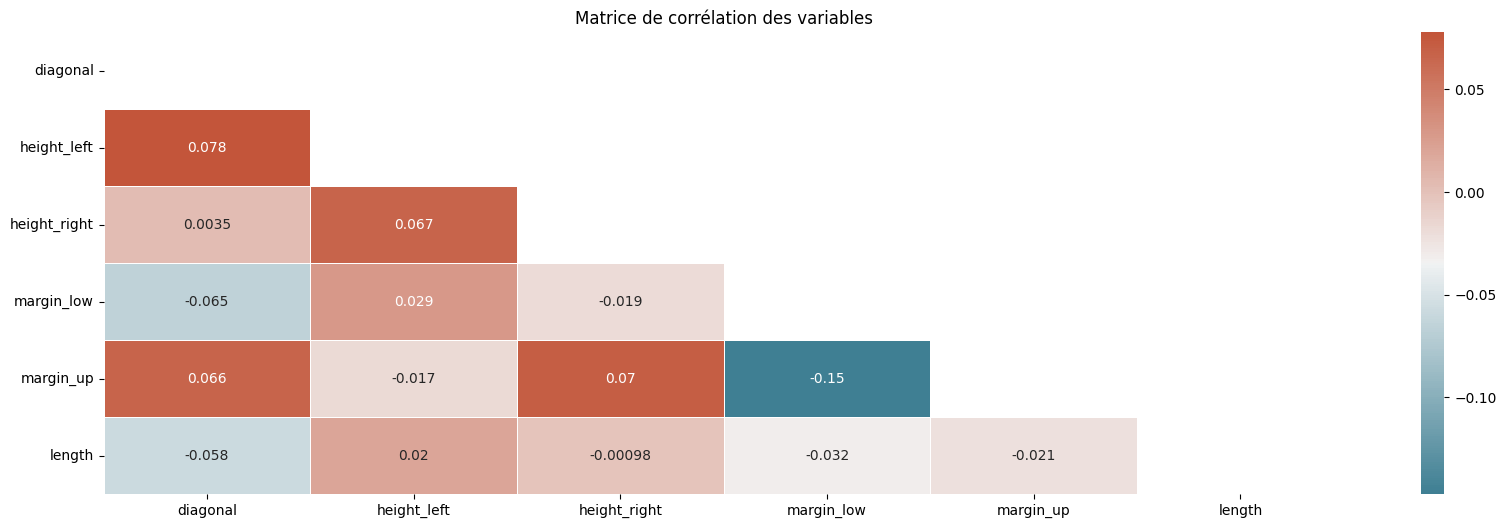

In [ ]:
matrix = filled_dataset_without_is_genuine_false.corr(method = 'spearman')

correlation_matrix(matrix)

Il n'y a pas de corrélation significative des variables quand is_genuine est faux

### b ) Pairplot des variables avec la variable is_genuine en teinte

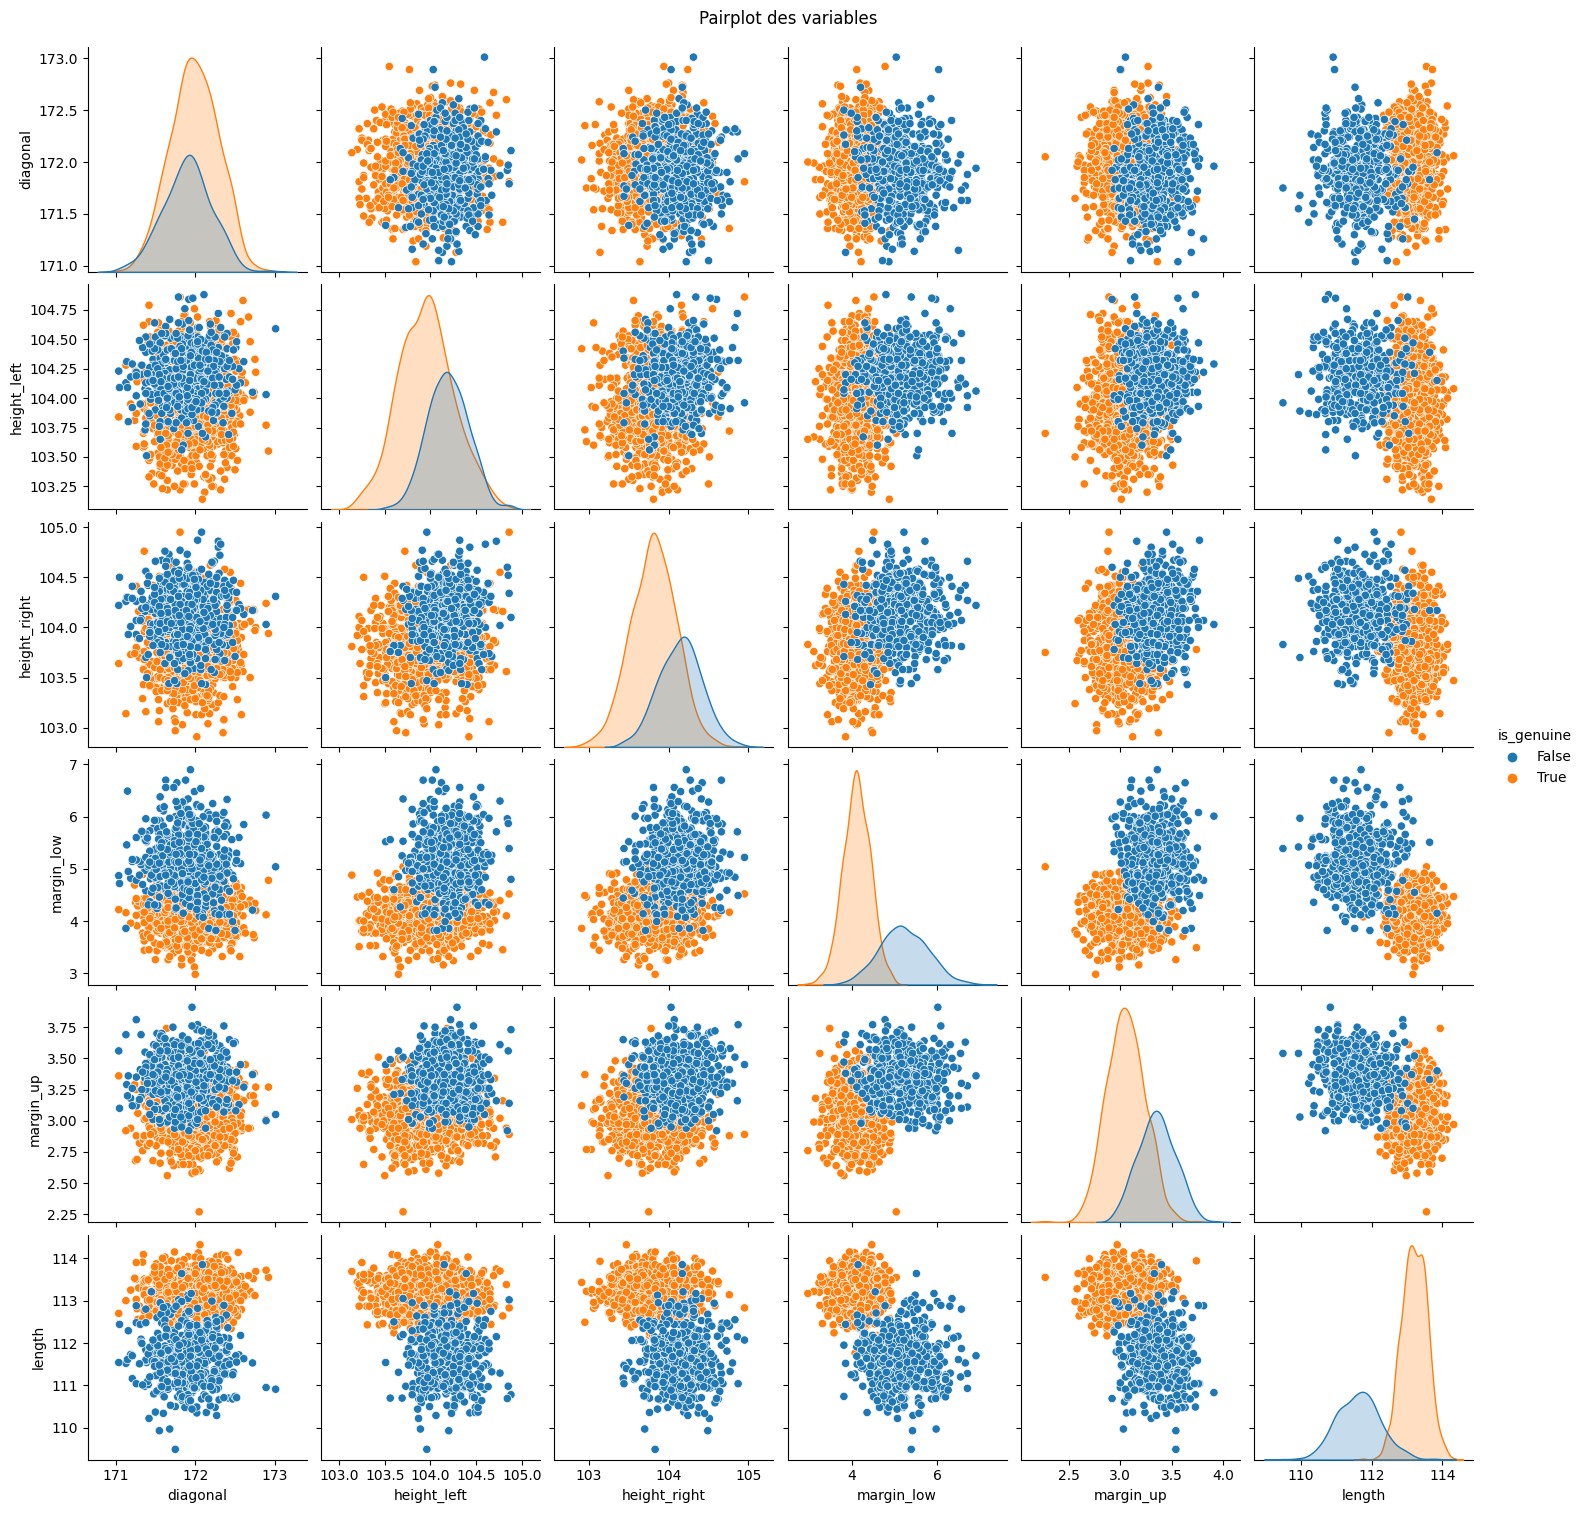

In [ ]:
pp = sns.pairplot(filled_dataset, hue = 'is_genuine')
pp.fig.suptitle('Pairplot des variables', y = 1.01)
plt.show()

Concernant la différence de répartition des données vraies et fausses,cette réparttion semble diverger sur les variables suivantes :
<li>length</li>
<li>margin_up</li>
<li>margin_low</li>

### c) Distribution des données
--------------------------

Nous allons vérifier si les variables suivent une loi normale avec deux hypothèses H0 et H1.<br>
Pour se faire nous allons faire un test de Kolmogorov-Smirnov avec un seuil de significativité de 5%.<br>
H0 : les données de la variable suivent une loi normale dont la moyenne est similaire à celle de la variable et d'écart-type est égale à celui de la variable.<br>
H1 : les données de la variables ne suivent pas une loi normale.

Pour faciliter la tâche nous allons incrémenter les tests grâce à une variable features définit ci-dessous : 

In [ ]:
# features represents all the variable expet is_guenuine

features = features[1:]


On créé une fonction d'incrémentation des tests et d'affichage des résultats sous forme de tableau : 

In [ ]:
def distribution_gauss(df,features):
    """Kolmogorov 2 samples test and display results tests for the variables"""
    h0_validation = []
    p_values = []
    for feature in features : 
        stat, p = stats.kstest(df[feature], np.random.normal(np.mean(df[feature]),np.std(df[feature]),len(df)))
        p_values.append(round(p,3))
        if p >= 0.05:
            h0_validation.append(True)
        else : h0_validation.append(False)

    distribution_test_df = pd.DataFrame({'Variables' : features, 'p values' : p_values,'Distribution normale' : h0_validation})
    
    display(distribution_test_df)

#### Distribution des données sans distinction de vrais ou de faux
---------------------------------------------

In [ ]:
distribution_gauss(filled_dataset,features)

,Variables,p values,Distribution normale
0,diagonal,0.676,True
1,height_left,0.144,True
2,height_right,0.493,True
3,margin_low,0.000,False
4,margin_up,0.385,True
5,length,0.000,False


4 variables sont distribuées normalement si on ne sépare pas les vrais et les faux : 
<li>diagonal</li>
<li>height_left</li>
<li>height_right</li>
<li>margin_up</li>

#### Distribution des données sans distinction si is_genuine est vrai
---------------------------------------------------

In [ ]:
distribution_gauss(filled_dataset_without_is_genuine_true,features)

,Variables,p values,Distribution normale
0,diagonal,0.706,True
1,height_left,0.706,True
2,height_right,0.668,True
3,margin_low,0.186,True
4,margin_up,0.591,True
5,length,0.743,True


Toutes les données sont normalement distribuées si on ne tient compte que des vrais

#### Distribution des données sans distinction si is_genuine est faux
------------------------------------------------

In [ ]:
distribution_gauss(filled_dataset_without_is_genuine_false,features)

,Variables,p values,Distribution normale
0,diagonal,0.450,True
1,height_left,0.812,True
2,height_right,0.976,True
3,margin_low,0.989,True
4,margin_up,0.498,True
5,length,0.249,True


Toutes les données sont normalement distribuées si on ne tient compte que des faux

# 3. Remplissage des valeurs manquantes
--------------------------------

## 3.1 Méthode des moyennes
-------------------------

### Concept
-------------------------

On rempli les données manquantes de la variables margin_low par la moyenne de la variable

### Application
---------------------------------

On définit la moyenne de la variable

In [ ]:
margin_low_average = round(filled_dataset.margin_low.mean(),2)
print(margin_low_average)

4.49


On créé un dataframe à partir de notre filled_data_set.

In [ ]:
predict_avg_df = filled_dataset.copy()

On ajoute une colonne prédiction contenant notre moyenne qui sert de base à notre prédiction

In [ ]:
predict_avg_df['predict_avg'] = margin_low_average

On calcule les résidus, soit notre valeur de margin_low - la moyenne de margin low

In [ ]:
predict_avg_df['residual_values'] = predict_avg_df.margin_low - margin_low_average

On calcule le pourcentage d'erreur,soit residual_values/margin_low

In [ ]:
predict_avg_df['error_percent_avg'] = round((predict_avg_df.residual_values / predict_avg_df.margin_low*100),2)

On obtient le data frame suivant qui servira dans notre choix de la méthode employée

In [ ]:
predict_avg_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predict_avg,residual_values,error_percent_avg
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.49,0.03,0.66
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.49,-0.72,-19.10
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.49,-0.09,-2.05
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.49,-0.87,-24.03
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.49,-0.45,-11.14


## 3.2 Régression linéaire
-------------------------------

### Concept
-------------------------

Un modèle de régression linéaire classique suit le modèle suivant :<br><br>
$$
{y} = {a}{x}+{b}
$$
<br>
Nous avons précédemment vu que la variable la plus corrélée à notre variable margin_low est la variable length.
Nous auront donc comme variable à expliquer margin_low et comme variable explicative length.
Nous utiliserons la méthode des moindres carrés grâce à ols de statsamodels

In [ ]:
X = filled_dataset.length
Y = filled_dataset.margin_low

X = sm.add_constant(X)

model  = sm.OLS(Y,X)
predict = model.fit()

params_df = predict.params
coefficient_r = predict.rsquared
print(params_df)
print(coefficient_r)

const     61.596009
length    -0.506857
dtype: float64
0.4445592708293491


Grâce à la méthode des moindres carrés, on obtient l'équation suivante : 
$$
{y}_{i} = {0.51}{x}_{i}+{61.61}
$$
Le coefficient de corrélation est quand à lui de 0.44 qui indique la précision de notre régression vis à vis de notre jeu de donnée.<br>
Le modèle est assez peu significatif<br><br>
On devra vérifier l'hypothèses suivantes : 
<li>Les résidus suivent une distribution normale centée sur une moyenne de 0</li>
<li>Le nuage de points des résidus en fonction de Ŷ (prévision) ne doit pas avoir de forme particulière.</li>
<li>L'indépendance des résidus</li>
<br>On décrira aussi le coefficient R²

On créé un dataframe predict_ols_df copie de filled_dataset

In [ ]:
predict_ols_df =filled_dataset.copy()

On ajoute une colonne predict_ols au df predict_ols_df

In [ ]:
predict_ols_df['predict_ols'] = predict_ols_df.length * params_df[1] + params_df[0]


On calcule les valeurs résiduelles et on le ajoute à predict_ols_df

In [ ]:
predict_ols_df['residual_values'] = predict_ols_df.margin_low - predict_ols_df.predict_ols

On calcule le pourcentage d'erreur et l'ajoute au predict_ols_df

In [ ]:
predict_ols_df['error_percent_ols'] = round((predict_ols_df.residual_values/predict_ols_df.margin_low)*100,2)

On a le tableau suivant : 

In [ ]:
predict_ols_df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predict_ols,residual_values,error_percent_ols
0,True,171.81,104.86,104.95,4.52,2.89,112.83,4.407281,0.112719,2.49
1,True,171.46,103.36,103.66,3.77,2.99,113.09,4.275498,-0.505498,-13.41
2,True,172.69,104.48,103.50,4.40,2.94,113.16,4.240018,0.159982,3.64
3,True,171.36,103.91,103.94,3.62,3.01,113.51,4.062618,-0.442618,-12.23
4,True,171.73,104.28,103.46,4.04,3.48,112.54,4.554270,-0.514270,-12.73


Fonction qui :
<li> Vérifie la normailté des résidus</li>
<li>Trace les résidus sur la prédiction pour vérifier l'homoscédasticité des résidus</li>
<li>Vérifie l'indépendance des résidus</li>


In [ ]:
def residual_normality(datas):
    plt.hist(datas.residual_values)
    plt.title('Répartition des valeurs résiduelles')
    plt.show()
    p, stat = stats.kstest(datas.residual_values,stats.norm.cdf)
    print(p)


def residual_scatter(datas,predict):
    fig = px.scatter(datas,x= datas[predict],y = datas.residual_values)
    fig.show()

def resisual_durbin(datas):
    durbin_watson(datas.residual_values)

On vérifie si les résidus suivent une loi normale de moyenne 0 à l'aide d'un test de Kolmogorov-Smirnov.<br><br>
H0 : Les résidus suivent une loi normale de moyenne 0.
H1 : Les résidus ne suivent pas une loi normale de moyenne 0.

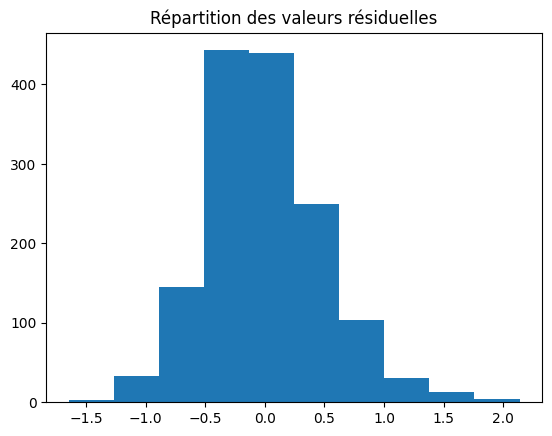

0.18483989273649587


In [ ]:
residual_normality(predict_ols_df)

On peut validé H0 les résidus suivent une loi normale de moyenne 0

On vérifie l'homoscédasticité des résidus en traçant un nuage de point des résidus sur les prévisions. Si on ne constate pas l'apparition d'une structure particulière alors on peut affirmer qu'il y a homoscédasticité des résidus.

In [ ]:
residual_scatter(predict_ols_df,'predict_ols')

On ne constate pas l'apparition d'une structure particulère. Il y homoscédasticité des résidus.

On vérifie si les résidus sont indépendants à l'aide d'un test de durbin watson.<br><br>
<li>H0 : Les résidus sont indépendant</li>
<li>H1 : Les résidis ne sont pas indépendants</li>

In [ ]:
durbin_watson(predict_ols_df.residual_values)

1.8655253979522592

Le résultat du test est compris en 1.5 et 2.5. Les résidus sont indépendants.

## 3.3 Régression linéaire multiple
--------------------------------

### Concept
-------------------------

Le modèle de régression linéaire multiple est l’outil statistique le plus habituellement mis en œuvre pour l’étude de données multidimensionnelles.<br><br>
`Le modèle : ` <br><br>
Une variable quantitative Y dite à expliquer est mise en relation avec p variables quantitatives X1, . . . , Xp dites explicatives.<br><br>

Les données sont supposées provenir de l’observation d’un échantillon statistique de taille n (n > p + 1).<br><br>

L'équation suivante justifie le modèle linéaire : <br>
$$
{y_i} = {\beta}_{1}*{x^1}_{_i} + {\beta}_{2}*{x^2}_{_i} + ... + {\beta}_{p}*{x^p}_{_i} + b +{\epsilon}_{_i}
\newline
{\beta}_{p} = \text{Les paramètres inconnus à déterminer}
\newline
\sum_{i = 0}^{n}({\beta}_{p}*{x^p}_{_i}) = \text{L'équivalent de la pente a du modèle régression linéaire}
\newline
{b} = \text{Ordonnée à l'origine de notre modèle de regression linéaire}
\newline
{\epsilon}_{_i} = \text{Les termes d'erreurs}

$$
On devra vérifier l'hypothèses suivantes : 
<li>Les résidus suivent une distribution normale centée sur une moyenne de 0</li>
<li>Le nuage de points des résidus en fonction de Ŷ (prévision) ne doit pas avoir de forme particulière.</li>
<li>L'indépendance des résidus</li>
<br>On décrira aussi le coefficient R²

### Application
---------------------------------

Notre modèle de régression linéaire multiple sera entrainée sur les lignes aux valeurs non-vides.<br><br>
Ici la variable à expliquer sera margin_low et les variables explicatives seront les autres variable.<br>
Il est à noter que la variables is_genuine qui est booléenne sera encodé pour se transformer en variable quantitative.<br><br>


On découpe nos variables explicatives et à expliquer en variable d'entrainement et de test grâce à la fonction train_test_split du module model_selection de scikit-learn.<br><br>
La répartition de l'entrainement et du test se fait comme suit : <br><br>
<li>Entrainement 70% des valeurs</li>
<li>Test 30% des valeurs</li>
Ici la répartition se fait sur la base d'un échantillonage aléatoire.

L'application du modèle s'effectuera sur le filled_dataset

On sépare notre variable à expliquer (Y) de nos variables explicatives :

In [ ]:
Y = filled_dataset[missing_value_column]
X = filled_dataset.drop(columns=missing_value_column)
X= X.drop(columns=['is_genuine'])
print(Y.shape)
print(X.shape)

(1463, 1)
(1463, 5)


On obtient une variables à expliquer et 6 variables explicatives.

On crée notre échantillonage sur les variables X_train, X_test, y_train, y_test :

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

On initie entraine notre modèle de régression

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

reg_train_score = reg.score(X_train,y_train)
reg_test_score = reg.score(X_test,y_test)

Nos prédisons les valeurs margin_low à partir de x_test.

In [ ]:
y_pred = reg.predict(X_test)

On ajoute nos résultat à la table y_test

In [ ]:
y_test['margin_low_pred'] = y_pred

On calcule nos valeurs résiduelles soit margin_low - margin_low_pred

In [ ]:
y_test['residual_values'] = y_test.margin_low - y_test.margin_low_pred

On calcule le pourcentage d'erreur et l'ajoute à y_test

In [ ]:
y_test['error_percent_multi'] = round((y_test.residual_values/y_test.margin_low)*100,2)


On obtient le df suivant : 

In [ ]:
y_test.head()

,margin_low,margin_low_pred,residual_values,error_percent_multi
147,4.20,4.230668,-0.030668,-0.73
941,4.23,4.307038,-0.077038,-1.82
980,4.09,4.378571,-0.288571,-7.06
868,3.90,4.162648,-0.262648,-6.73
683,4.47,4.207948,0.262052,5.86


### Vérification de la validité du modèle
------------------------------------

Les valeurs résiduelles ont l'air de suivre une loi normale centrée autour de 0.

#### On teste la répartition des valeurs résiduelles. H0 les valeurs résiduelles sont répartis de manière normales autour de 0. Notre valeur seuil est de 0,05 (p value)

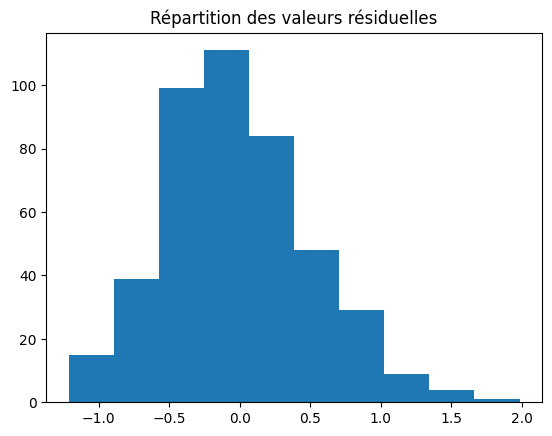

0.18217711124300898


In [ ]:
residual_normality(y_test)


p value est supérieur à 0,05 on ne peut rejeter l'hytpothèse H0 selon laquelle les données suivent une loi normale centrée à 0.

#### On étudie nos valeurs prédites en fonction de des valeurs résiduelles : 

In [ ]:
y_test = y_test.join(dataset.is_genuine)

In [ ]:
residual_scatter(y_test,'margin_low_pred')

La répartition des valeurs ne suit pas une forme particulière

#### Test de Durbin-Watson d'autocorrélation des valeurs résiduelles (indépendance)

#### H0 : Il n'y a pas d'autocorrélation des résidus ou les résidus sont indépendant les uns des autres
#### H1 : IL y a auto-corrélation des résidus
#### Pour valider l'hypothèse H0 il faut que les résultats du test soit compris entre 1.5 et 2.5

In [ ]:
durbin_watson(y_test.residual_values)

2.1127337635728165

#### Le résultat du test est compris entre 1.5 et 2.5 on ne peut pas rejeter l'hypothèse H0, les résidus sont indépendants les uns des autres

#### On détermine notre R² (coefficient de détermination) qui définit la qualité de la prédiction

In [ ]:
print(reg_test_score)
print(reg_train_score)

0.45212458501148645
0.4889508821940308


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_test.index, y = y_test.margin_low,name = 'valeurs de margin_low',mode='markers'))
fig.add_trace(go.Scatter(x = y_test.index, y = y_test.margin_low_pred,name = 'valeurs prédites',mode = 'markers'))
fig.show()

#### Notre R² est de 0,47 pour nos données d'entrainement et 0.47 pour nos données test.

#### Pour chaque variables nous avons les coefficients beta suivants et la constante suivantes : 

In [ ]:
beta_columns = ['diagonal','height_left','height_right','margin_up','length']
beta_coeff = reg.coef_

model_df = pd.DataFrame(columns=beta_columns,data=beta_coeff)

model_df['constante'] = reg.intercept_
display(model_df)

,diagonal,height_left,height_right,margin_up,length,constante
0,-0.114447,0.139652,0.277082,0.217135,-0.416345,27.072058


#### On a donc :  

#### <li>Des valeurs résiduelles qui suivent une distribution gaussienne autour de 0.</li>
#### <li>Pas de forme particulière quand on trace margin_low pred en fonction des valeurs résiduelles. Il y a homoscédasticité des résidus</li>
#### <li> Les résidus sont indépendants les uns autres.
#### <li>Un coefficient R² entre 0.45 et 0.50</li>

#### Notre modèle semble cohérent

## 3.4 Choix de la méthode de remplissage
-------------------------------

#### Afin de comparer nos modèles nous allons comparer pourcentage d'erreurs des valeurs résiduelles vis à vis des valeurs d'origines sur l'échantillon y_test de notre modèle de régression multiple 

On créé le df de comparaison percent_error_df qui est la fusion des trois pourcentages d'erreurs

In [ ]:
percent_error_df = pd.merge(y_test['error_percent_multi'], predict_avg_df['error_percent_avg'],left_index=True,right_index=True)
percent_error_df = pd.merge(percent_error_df,predict_ols_df['error_percent_ols'],left_index=True,right_index=True)


On obtient le tableau suivant : 

In [ ]:
percent_error_df.head()

,error_percent_multi,error_percent_avg,error_percent_ols
147,-0.73,-6.90,-4.45
941,-1.82,-6.15,-1.44
980,-7.06,-9.78,0.55
868,-6.73,-15.13,-5.86
683,5.86,-0.45,5.49


Nous allons comparer ces valeurs grâce à un boxplot :

In [ ]:
fig = make_subplots(rows=1, cols=3,
specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]],shared_yaxes='all')

fig.add_trace(go.Box(y = predict_avg_df['error_percent_avg'],name = 'Méthode de la moyenne'), row= 1,col = 1)
fig.add_trace(go.Box(y = predict_ols_df['error_percent_ols'],name = 'Modèle de régresison linéaire simple'), row= 1,col = 2)
fig.add_trace(go.Box(y = y_test['error_percent_multi'],name = 'Modèle de régression linéaire multiple'), row= 1,col =3)

fig.update_layout(title = "Boxplots de comparaison de précision des méthodes")

fig.show()


#### La méthode la plus précise semble être la méthode de régression linéaire mutiple.
#### En effet, c'est la méthode avec la précision la plus forte au vu du box plot et qui a un meilleur R² que la régression linéaire simple 0.6 > 0.44
#### La précision des modèles vont ainsi : 
#### 1. Modéle de régression linéaire multiple
#### 2. Modèle de régression linéaire simple
#### 3. Méthode d'ajout de la moyenne

### On applique donc la modèle de régression linéaire multiple à nos valeurs manquantes.
-----------------------------------------------

#### On sépare nos variables explicatives de notre variable à expliquer dans notre table missing_values_df

In [ ]:
y_missing_test = missing_values_df.margin_low
x_missing_test = missing_values_df.drop(columns=missing_value_column)
x_missing_test = x_missing_test.drop(columns = ['is_genuine'])

#### On applique notre modèle de régression linéaire multiple

In [ ]:
missing_pred = reg.predict(x_missing_test)

#### On rempli les valeurs manquantes dans notre dataframe missing_value_df

In [ ]:
missin_values_cop_df = missing_values_df.copy()

missin_values_cop_df['margin_low'] = np.around(missing_pred,2)


missing_values_df = missin_values_cop_df
display(missing_values_df.head())

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.31,3.25,112.79
99,True,171.93,104.07,104.18,4.40,3.14,113.08
151,True,172.07,103.80,104.38,4.43,3.02,112.93
197,True,171.45,103.66,103.80,4.31,3.62,113.27
241,True,171.83,104.14,104.06,4.66,3.02,112.36


#### On trace un nuage de point avec nos valeurs remplies et nos valeurs initialement remplies

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = missing_values_df.index, y = missing_values_df.margin_low,name = 'valeurs de margin_low remplies',mode='markers',marker_color = 'red'))
fig.add_trace(go.Scatter(x = filled_dataset.index, y = filled_dataset.margin_low,name = 'valeur de margin_low déjà remplies',mode = 'markers',marker_color = 'grey'))
fig.show()

#### On fait un concatener entre missing_values_df et filled_dataset pour mettre à jour notre dataset final

In [ ]:
dataset = pd.concat([filled_dataset,missing_values_df])

On obtient le df suivant

In [ ]:
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# 4. Clustering et méthode ACP
---------------------------

On créé une table clustering_df copie de notre dataset

In [ ]:
clustering_df  = dataset.copy()

On exclut notre variable à prédire,is_genuine, de notre jeu de donnée.

In [ ]:
clustering_df = clustering_df.drop(columns=['is_genuine'])

On obtient le df suivant :

In [ ]:
clustering_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


On redéfinit features la variable des colonnes de clustering_df

In [ ]:
features = clustering_df.columns

Soit X les valeur du df clustering_df

In [ ]:
X = clustering_df.values

On centre et réduit les données afin qu'elles soient à la même échelle

In [ ]:
scaler = StandardScaler()
scaled_X  = scaler.fit_transform(X)


En ayant centré réduit les données on s'attend à obtenir une moyenne de 0 (car centrage) et écart de type de 1 (car réduction) :

In [ ]:
idx = ["mean", "std"]   

pd.DataFrame(scaled_X).describe().round(2).loc[idx, :]

,0,1,2,3,4,5
mean,0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


Les résultat obtenu sont corrects le centrage et réduction des données est réussi

## 4.1 Nombre de cluster optimum : coefficient de silhouette
--------------------------------

### On définit un graphique représentant le coefficient de silhouette

In [ ]:
silhouette_tab = []


for i in range(2,10,1):
    kmeans = KMeans(n_clusters=i, n_init="auto")
    cluster_labels = kmeans.fit_predict(scaled_X)
    silhouette_tab.append(silhouette_score(scaled_X,cluster_labels))

fig = px.line(silhouette_tab)

fig.update_layout(
    xaxis_title="Clusters", yaxis_title="Coefficient de silhouette moyen", title = 'Graphique des coefficients de silhouette', showlegend = False
)

fig.show()

### Au vu de la courbe du coefficient de silhouette et de la variable booléenne is_genuine, nous allons représenter graphiquement nos données au moyen de 2 clusters

## 4.2 Eblouis des valeurs propres détermination du nombre de composantes
--------------------------------

On définit le nombre de variables

In [ ]:
nb_features = len(features)
print(nb_features)

6


### Instanciation du module PCA

In [ ]:
pca=PCA(n_components=nb_features)


### Passage des données centreés réduites dans le modèle PCA.

In [ ]:
pca.fit(scaled_X)

PCA(n_components=6)

### On définit le critère de Kaiser, critère du choix du nombre de composantes.

In [ ]:
kaiser_crietria = round(100/len(clustering_df.columns),2)
print(kaiser_crietria)

16.67


### Calcul de la variance expliquée pour chaque composante

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)

array([43.28, 16.96, 13.03, 11.82,  9.61,  5.3 ])

### Calcul de la somme cumulé des variances expliquées pour un nombre de cluster définit

In [ ]:
scree_cum = scree.cumsum().round(2)

components = [1,2,3,4,5,6]
scree_cum

array([ 43.28,  60.24,  73.27,  85.09,  94.7 , 100.  ])

On créé et affiche le df des variance expliquée en fonction de la composante

In [ ]:
scree_df = pd.DataFrame({'component' : components,'Variance expliqué en %' : scree})
HTML(scree_df.to_html(index=False))

component,Variance expliqué en %
1,43.28
2,16.96
3,13.03
4,11.82
5,9.61
6,5.30


### Graphique de l'éblouis avec une ligne horizontale représentant le critère de Kaiser 

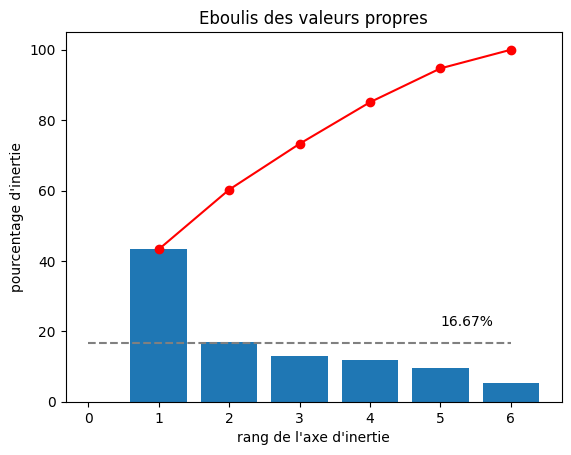

In [ ]:
x_list = range(1,nb_features+1)
list(x_list)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.hlines(kaiser_crietria,0,nb_features,colors= 'grey',linestyles='dashed')
plt.text(nb_features-1,kaiser_crietria+5, str(kaiser_crietria)+'%')
plt.show(block=False)

 ### Nous retiendrons les deux premiers composantes car ce sont les deux seules qui ont une variance expliquée au-dessus du coefficient de Kaiser qui est de 14,29 %.
 ### A eux deux ils ont une variance expliquée cumulée d'environ 60 %

## 4.3 Cercle de corrélation
-----------------------------

### Pour la suite de notre analyse on ne garde que les deux premières composantes

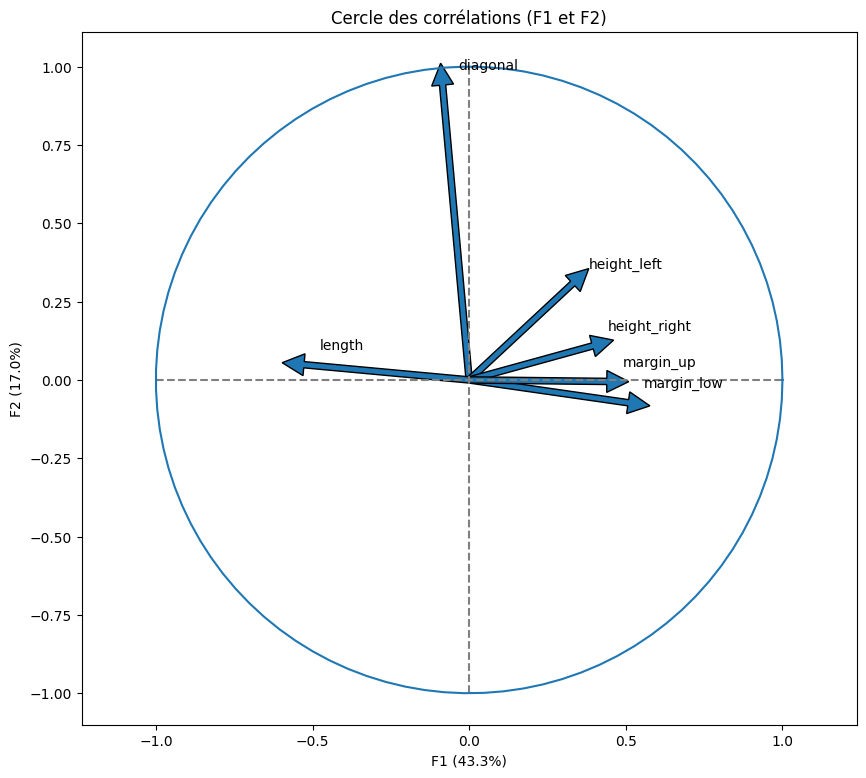

In [ ]:
x, y = 0,1

# Création du graphique des cercle de corrélation 
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Début de la flèche à l'origine du plan
             pca.components_[0, i],  #0 pour PC1
             pca.components_[1, i],  #1 pour PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

# Définition d'un array de 0 à 2*pi avec 100 valeurs (pour création du cercle (angle radians cercle trigonométrique))
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Création du cercle en utilisant pour x cos(angle radians => an) et y sin(angle radians => an=)
plt.axis('equal')
plt.show(block=False)

### Fait intéressant la variable diagonale influence la composante 2 et quasiment pas la première.
### Margin_low/length et is_genuine influence la composante 1 et quasiment pas la seconde.

## 4.3 Nombre de cluster optimum : coefficient de silhouette
--------------------------------

In [ ]:
pca_graph=PCA(n_components= 2)
pca_graph.fit(scaled_X)
X_graph_proj = pca_graph.transform(scaled_X)


### Au vu de la courbe du coefficient de silhouette et de la variable booléenne is_genuine nous allons représenter graphiquement nos données au moyen de 2 clusters

## 4.4 Représentation graphiques des clusters
-------------------------------

In [ ]:
columns_name = ['principal component 1','principal component 2']


# Création d'un df pour les composantes principales choisies
pca_cluster_df = pd.DataFrame(data= X_graph_proj, columns= ['principal component 1','principal component 2'])

# MOdification du df final avec cluster en appliquant la méthode des composantes princiaples


nb_cluster = 2

kmeans_1 = KMeans(n_clusters=nb_cluster, n_init= 'auto')
predictions = kmeans_1.fit_predict(X_graph_proj)

# Création de la fonction qui remplie le df des centroids pour chaque cluster
def create_centroid_tab(kmeans,columns_n):
    """Define component's centroid coordinates and put it in a table"""
    centroid_tab_names = []
    for i in range(1,nb_cluster + 1):
        centroid_names = 'group centroid ' + str(i)
        centroids_coordinates = kmeans_1.cluster_centers_
        centroid_tab_names.append(centroid_names)
    columns_centroids = np.array(columns_n)
    centroid_tab = pd.DataFrame(columns= columns_centroids, data= centroids_coordinates)
    centroid_tab['Nom du centoid'] = centroid_tab_names
    return centroid_tab


centroid_tab = create_centroid_tab(kmeans_1,columns_name)

# Création du graphique qui affiche les composantes principales (cluster en couleur) et leurs centroids (croix)
def draw_clusters_centroids(biased_dataset,centroid_tab, predictions,scree):
    """Draw ID s coordinates in terms of F1 and F2 draw cendroids of F1 and F2"""
    clustered = pd.concat([biased_dataset, pd.DataFrame({'group':predictions+1})], axis=1)
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = centroid_tab['principal component 1'],
                        y = centroid_tab['principal component 2'],
                        mode= 'markers',
                        text = centroid_tab['Nom du centoid'],
                        marker_color = 'red',
                        ))
    fig.update_traces(
    marker=dict(size=15, symbol="cross", line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)

    fig.add_trace(go.Scatter(x = clustered['principal component 1'],
                                y = clustered['principal component 2'],
                                marker = dict(color = ["orange", "red", "green", "blue"]),
                                mode= 'markers',
                                marker_color = clustered['group'],
                                ))
    fig.update_layout(showlegend = False,
                    title = 'Clustering avec deux composants principaux et centroids de classe',
                    title_font = dict(family ="Courier New, monospace",
                                        size = 18,
                                        color = 'black'),
                    xaxis_title='PC1('+str(scree[0])+' %)', yaxis_title='PC2('+str(scree[1])+' %)')

    fig.show()
    return clustered

pca_cluster_df = draw_clusters_centroids(pca_cluster_df,centroid_tab, predictions,scree)

### On ajoute les numéros de cluster aux df clustering_df

In [ ]:
clustering_df = pd.merge(clustering_df,pca_cluster_df['group'],left_index = True, right_index=True)

### On obtient le df suivant

In [ ]:
clustering_df.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,group
0,171.81,104.86,104.95,4.52,2.89,112.83,1
1,171.46,103.36,103.66,3.77,2.99,113.09,2
2,172.69,104.48,103.50,4.40,2.94,113.16,2
3,171.36,103.91,103.94,3.62,3.01,113.51,2
4,171.73,104.28,103.46,4.04,3.48,112.54,2


## 4.5 Les faux positifs du clustering
-------------------------------

### On sépare les vrais des faux

In [ ]:
clustering_df = clustering_df.join(filled_dataset['is_genuine'])

In [ ]:
clustering_true_df = clustering_df[clustering_df.is_genuine == True]
clustering_false_df = clustering_df[clustering_df.is_genuine == False]

### On compte le nombre d'occurences pour chaque groupe pour les vrais

In [ ]:
true_count_df = clustering_true_df.group.value_counts()
true_count_df

2    929
1     42
Name: group, dtype: int64

### On compte le nombre d'occurences pour chaque groupe pour les faux

In [ ]:
false_count_df = clustering_false_df.group.value_counts()
false_count_df

1    453
2     39
Name: group, dtype: int64

### Quel est le pourcenhtage de faux positif avec le clustering et de vrai positif ?

In [ ]:
error_percent = round((min(true_count_df)+min(false_count_df))/1500*100,2)
accuracy_score  = 100 - error_percent

true_podsitive_df = pd.DataFrame({'Accuracy score' : [accuracy_score],'Error rate' : [error_percent]})


In [ ]:
HTML(true_podsitive_df.to_html(index=False))

Accuracy score,Error rate
94.6,5.4


### Avec 5.4 % d'erreur nous pourrions utiliser comme méthode d'identification le clustering. 5.4 % d'erreur semble être une marge d'erreur acceptable
### Le résultat semble pouvoir être amélioré. Nous allons chercher d'autres métohodes de modélisation pour l'identification des faux billets.

# 5. Autres méthodes de modélisation, vers de meilleurs résultats ?
-------------------------------------

## 5.1 Encodage de is_genuine et Test Train Split
---------------------------

### Dans ce modèle nous souhaitons entrainer un modèle pour qu'il définisse avec le plus de précision les vrais et faux billets.
### Nous entrainerons le modèle sur le dataset complété.
### Notre variable à expliquer est la variable is_genuine et les variables explicatives sont les autres variables



Le df sur lequel nous allons travailler 

In [ ]:
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### Nous allons encoder la variable is_genuine :
### <li>True = 1</li>
### <li>False = 0</li>

In [ ]:
dataset['is_genuine'] = np.where((dataset.is_genuine ==True), 1,dataset.is_genuine)
dataset['is_genuine'] = np.where((dataset.is_genuine ==False), 0,dataset.is_genuine)


Le résultat de nos changements : 

In [ ]:
dataset.is_genuine.value_counts()

1    1000
0     500
Name: is_genuine, dtype: int64

## 5.2 Modélisations

Nos changements sont effectifs

### Nous allons définir X et Y dans le but de réaliser notre split

In [ ]:
X = dataset.drop(columns=['is_genuine'])
Y = dataset.is_genuine

### Nous réalisons notre train test split sur X et Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

### Nos échantillons sont répartis ainsi : 

In [ ]:
print(f"Nous avons X_train de dimensions de {X_train.shape} et X_test de dimensions {X_test.shape}")
print(f"Nous avons y_train de dimensions de {y_train.shape} et y_test de dimensions {y_test.shape}")

Nous avons X_train de dimensions de (1050, 6) et X_test de dimensions (450, 6)
Nous avons y_train de dimensions de (1050,) et y_test de dimensions (450,)


### 5.2.1 Dummy Classifier

#### On entraine nos données sur la valeur la plus fréquente (la stratégie most_frequent). Normalement toutes les valeurs de sortie devraient être de 1

In [ ]:
estimator = DummyClassifier(strategy= 'most_frequent')
estimator.fit(X_train,y_train)


DummyClassifier(strategy='most_frequent')

#### Affichons maintenant nos predictions en fonction de X_test. Ces prédictions sont notées y_pred.

In [ ]:
y_pred = estimator.predict(X_test)
pd.Series(y_pred).value_counts(normalize = True)

1    1.0
dtype: float64

#### Grâce au Dummy Classifier, on confirme notre hypothèse 100% des valeurs test prédites sont 1 soit vraies

### Pour nos données y_test, voici la répartition des 0 (faux) et des 1 (faux)

In [ ]:
y_test.value_counts(normalize=True).round(4)

1    0.64
0    0.36
Name: is_genuine, dtype: float64

### Pour nos données y_train voici la répartition des 0 (faux) et des 1 (faux)

In [ ]:
y_train.value_counts(normalize=True).round(4)

1    0.6781
0    0.3219
Name: is_genuine, dtype: float64

#### On définit une fonction qui nous donne le score de précision pour les données test et train

In [ ]:
def acc_score(estimator,X_train,y_train,X_test,y_test):
    """Calcul et affichage des score de test et de train"""
    tr_score = estimator.score(X_train,y_train).round(4)
    te_score = estimator.score(X_test,y_test).round(4)

    print(f"Le score de précision du modèle pour entraînement {tr_score} et le score de précision pour le test {te_score}\n")

#### On affiche les score pour le DummyClassifier

In [ ]:
acc_score(estimator,X_train,y_train,X_test,y_test)

Le score de précision du modèle pour entraînement 0.6781 et le score de précision pour le test 0.64



#### Matrice de confusion

On créé une fonction qui nous permet d'afficher correctement la matrice de confusion

In [ ]:

def confusion_display(y_test,y_pred):
    """Create and display confusion matrix"""
    mat = confusion_matrix(y_test,y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f'pred {i}' for i in mat.columns]
    mat.index = [f'test {i}' for i in mat.index]
    return mat

#### On affiche la matrice de confusion y_pred vs y_test dans le cadre du modèle DummyClassifier

In [ ]:
confusion_display(y_test, y_pred)

,pred 0,pred 1
test 0,0,162
test 1,0,288


#### On trouve 145 faux positifs sur nos 450 valeurs tests

#### Pour conclure sur le DummyClassifier nous avons un score test de 64.57 % de valeurs qui sont justes .
#### Prendre la valeur la plus fréquente comme base de notre modèle ne semble pas être la méthode la plus adaptée.
#### Nous allons effectuer une régression logistique dans le modèle suivant.

### 5.2.2 La régression logistique
---------------------------------

### Fonction qui :
### <li> créée X et Y en fonction des variables explicative et à expliquer choisies </li>
### <li>Utilise Train test split sur X et Y</li>
### <li>Entraine notre modèle avec X_train et y_train</li>
### <li>Définit notre y_pred à partir de X_test</li>
### <li> Affiche les coefficients du modèle</li>
### <li>Affiche les scores de précision de test et de train</li>
### <li>Affiche la matrice de confusion</li>
### <li>Calcule les scores  accuracy, précision, rappel et F-1 (voir définition ci-dessous)</li>
### <li>Renvoie une table avec l'estimateur et les scores du modèle</li>

In [ ]:
def log_regresision_test(dataset,feautures_excluded,test_name):
    """Process for Log regression for split to confusion matrix and compute scores"""
    X = dataset.drop(columns=feautures_excluded)
    Y = dataset.is_genuine

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    features = X.columns
    estimator = LogisticRegression(solver = 'liblinear')
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    coefficient_df = pd.DataFrame(np.concatenate([estimator.intercept_.reshape(-1,1),estimator.coef_],axis=1),
                index = ['coef'],
                columns=['constante']+list(features)).T
    print('Les coefficients du modèle : \n')
    display(coefficient_df)
    print('La matrice de confusion : \n')
    mat = confusion_display(y_test, y_pred)
    display(mat)
    
    true_negative = mat.iloc[0,0]
    false_positive = mat.iloc[0,1]
    false_negative = mat.iloc[1,0]
    true_positive = mat.iloc[1,1]

    accuracy_score = (true_positive+true_negative)/(true_negative+false_positive+false_negative+true_positive)
    precision_score = true_positive/(true_positive+false_positive)
    recall_score = true_positive/(true_positive+false_negative)
    f_1_score = 2 * ((precision_score*recall_score)/(precision_score+recall_score))

    labels = ['Accuracy score','Precision score','Recall score','F-1 score']
    values = [accuracy_score,precision_score,recall_score,f_1_score]
    results_df = pd.DataFrame()

    results_df.index = labels
    results_df[test_name] = values
    est_results = [results_df,estimator]
    return est_results

    


### Avec toutes les variables
----------------------------------------

In [ ]:
features_excluded =['is_genuine']

test_1_df = log_regresision_test(dataset,features_excluded,'All variables')[0]

Les coefficients du modèle : 



,coef
constante,-0.008351
diagonal,-0.222032
height_left,-1.345759
height_right,-2.183551
margin_low,-3.391475
margin_up,-2.810866
length,3.821370


La matrice de confusion : 



,pred 0,pred 1
test 0,144,2
test 1,4,300


### Avec les variables : diagonal, height left, height right
---------------------------------------

In [ ]:
features_excluded =['is_genuine','length', 'margin_low','margin_up']

test_2_df = log_regresision_test(dataset,features_excluded,'diagonal, height left, height right')[0]

Les coefficients du modèle : 



,coef
constante,0.022828
diagonal,2.578911
height_left,-1.623078
height_right,-2.634527


La matrice de confusion : 



,pred 0,pred 1
test 0,71,64
test 1,40,275


### Avec les variables : length, margin_low, margin_up, height left, height right
---------------------------------------

In [ ]:
features_excluded =['is_genuine','diagonal']

test_3_df = log_regresision_test(dataset,features_excluded,'length, margin_low, margin_up, height left, height right')[0]

Les coefficients du modèle : 



,coef
constante,-0.014411
height_left,-1.843099
height_right,-2.010314
margin_low,-3.552754
margin_up,-2.570977
length,3.784814


La matrice de confusion : 



,pred 0,pred 1
test 0,151,5
test 1,2,292


### Avec les variables : length, margin_low, margin_up
--------------------------------------

In [ ]:
features_excluded =['is_genuine','diagonal','height_left','height_right']

test_4_df = log_regresision_test(dataset,features_excluded,'length, margin_low, margin_up')[0]

Les coefficients du modèle : 



,coef
constante,-0.395989
margin_low,-5.131308
margin_up,-5.748439
length,0.380966


La matrice de confusion : 



,pred 0,pred 1
test 0,141,15
test 1,7,287


Heatmap récapitulative des différents scores en fonction des modèles

In [ ]:
summary_df = test_1_df.join(test_2_df)
summary_df = summary_df.join(test_3_df)
summary_df = summary_df.join(test_4_df) 

## Définition des concepts 
----------------------------------


## <li>Les vrais positifs (VP) : les faux billets prédits faux</li>
## <li>Les vrais négatifs (VN) : les vrais billets prédits vrais</li>
## <li>Les faux positifs (FP) : les vrais billets prédits faux</li>
## <li>les faux négatifs (FN) : les faux billets prédits vrais </li>



## Accuracy score :
$$
\frac {VP+VN}{VP+VN+FP+FN}
$$
## Score de précision :  
$$
\frac {VP}{VP+FP}
$$
## Score de rappel :
$$
\frac {VP}{VP+FN}
$$
## Score F-1 :
$$
{2}\times{\frac{{Précision}\times{Rappel}}{Précision + Rappel}}
$$

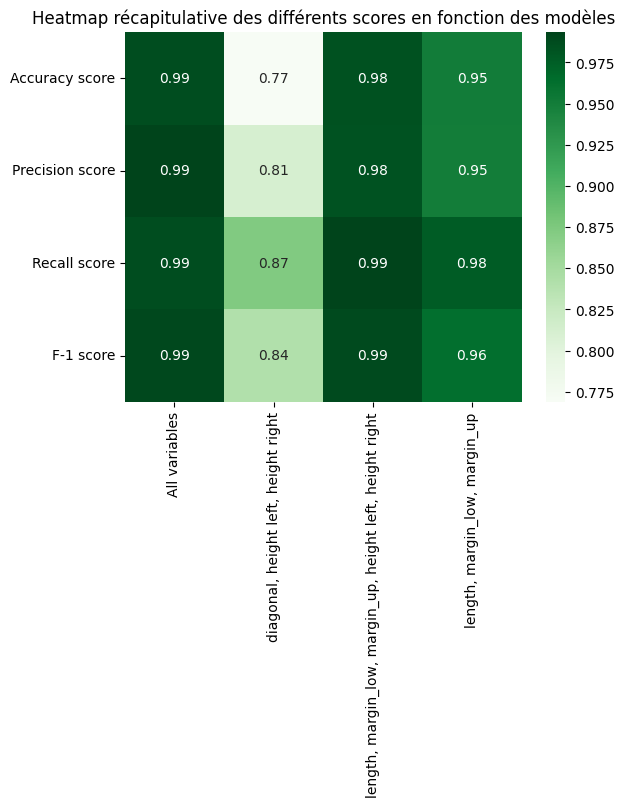

In [ ]:


sns.heatmap(summary_df,cmap="Greens", annot = True)

plt.title('Heatmap récapitulative des différents scores en fonction des modèles')
plt.show()

## Parmi tous les modèles entrainés, le modèle de régression logistique avec `toutes les variables` est le plus précis sur tous les scores notamment sur le score de rappel. `C'est le modèle choisi.`
## L'autre modèle qui est quasiment aussi efficace, est le modèle de régression logistique sans la variable diagonal en variable explicative.

In [ ]:
features_excluded =['is_genuine','diagonal']


estimator = log_regresision_test(dataset,features_excluded,'length, margin_low, margin_up, height left, height right')[1]

Les coefficients du modèle : 



,coef
constante,-0.014021
height_left,-1.612068
height_right,-1.988194
margin_low,-3.665756
margin_up,-2.683874
length,3.558232


La matrice de confusion : 



,pred 0,pred 1
test 0,148,3
test 1,1,298


# 6. Conclusion et application du modèle choisi au jeu de données de production de billets

## On charge le fichier csv des billets à tester :

In [ ]:
billet_test_df = pd.read_csv(PATH + 'billets_production.csv')
billet_test_df

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## On définit nos valeurs explicatives X_prod_test

In [ ]:
X_prod_test = billet_test_df.drop(columns=['id','diagonal'])

y_pred_prod = estimator.predict(X_prod_test)
y_pred_prod

array([0, 0, 0, 1, 1])

## On convertit les 0 et 1 de la prediction en Vrai ou faux (0 = Faux, 1 = Vrai)
## On ajoute nos prédictions dans une colonne is_genuine de notre df

In [ ]:
is_genuine = []
for i in y_pred_prod:
    if i == 0:
        is_genuine.append(False)
    else: is_genuine.append(True)

billet_test_df.insert(0, 'is_genuine', is_genuine)


## On obtient le df suivant

In [ ]:
display(billet_test_df)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,False,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,False,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,False,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,True,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,True,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## On enregistre nos résulat sous forme en csv dans le fichier results

In [ ]:
PATH = '~/project10/results/'

billet_test_df.to_csv(PATH + 'billets_tested.csv',encoding='utf-8',index=False)

# 7. Conclusion
--------------------------------------------

# Le modèle choisi nous indique que les trois premiers billets sont faux et les deux derniers vrais avec environ 99% de précision.